# NEMA Photoelectric

- Photoelectric interaction in PETALO

In [1]:
import Pkg

In [731]:
Pkg.add.(["HTTP", "Plots", "DataFrames", "HDF5","DrWatson", "StatsBase", "PhysicalConstants"]);

In [504]:
Pkg.add.(["Test"]);

In [48]:
Pkg.add.(["VegaLite","VegaDatasets"]);

In [129]:
Pkg.add.(["LsqFit","GLM"])

2-element Vector{Nothing}:
 nothing
 nothing

In [4]:
using LsqFit
using GLM

In [745]:
using HTTP
using Plots
using VegaLite
using VegaDatasets
using DataFrames
using HDF5
using DrWatson
using Test
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [6]:
using Glob
using CSV

In [7]:
using Statistics
using StatsBase
using Printf

In [524]:
using Logging

In [8]:
@quickactivate "JPetalo"

In [9]:
pwd()

"/Users/jj/JuliaProjects/JPetalo/notebooks"

In [10]:
datadir()

"/Users/jj/JuliaProjects/JPetalo/data"

In [11]:
srcdir()

"/Users/jj/JuliaProjects/JPetalo/src"

In [183]:
include(srcdir("jpetalo.jl"))

Main.JPetalo

In [742]:
import Unitful:
    nm, μm, mm, cm, m, km, inch, ft, mi,
    ac,
    mg, g, kg,
    Ra, °F, °C, K,
    rad, °,
    ns, μs, ms, ps, s, minute, hr, d, yr, Hz,
    eV,
    μJ, mJ, J,
	mW, μW, W,
    A, N, mol, mmol, V, L, mL, μL, M

In [525]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

In [310]:
function grfq(q)
    return Float32(326.9 + 0.0226 * q)
end
rfq(q::Float32) = grfq(q)
rfq(q::Float64) = grfq(q)

rfq (generic function with 2 methods)

In [311]:
function grfq2(q)
    return Float32(297.85 + 0.031 * q)
end
rfq2(q::Float32) = grfq(q)
rfq2(q::Float64) = grfq(q)

rfq2 (generic function with 2 methods)

# Characterization of PETALO

### Read a summary data frame with photoelectric interactions

In [799]:
drx = datadir("nema3df")
input = string(drx,"/nemadf_f200_q2_1800_3000_kmeans_phot.csv")
n3df = DataFrame(CSV.File(input));

In [800]:
println(names(n3df))

["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "rq1", "rq2", "t1", "t2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]


## Dependence of energy with radius of interaction
- Histograming the energy deposited in the SiPMs yields a wide and non gaussian distribution
- The reason is that the energy deposited in the SiPMs depends of the radius at which the gamms interacted.
- The relation is roughly linear
- This dependence can be used to define an estimator, "rq" of the radius of interaction

### Roughly linear relation between q and r

In [699]:
hq, phq = JPetalo.hist1d(n3df.q1, "q (pes)", 50, 0.0, 4000.0);

In [701]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.r1,n3df.q1, 250, "r (mm)", "q (pes)");
xe,ye,hrrq,phrrq = JPetalo.hist2d(n3df.r1,n3df.rq1, 250, "r (mm)", "rq (mm)");

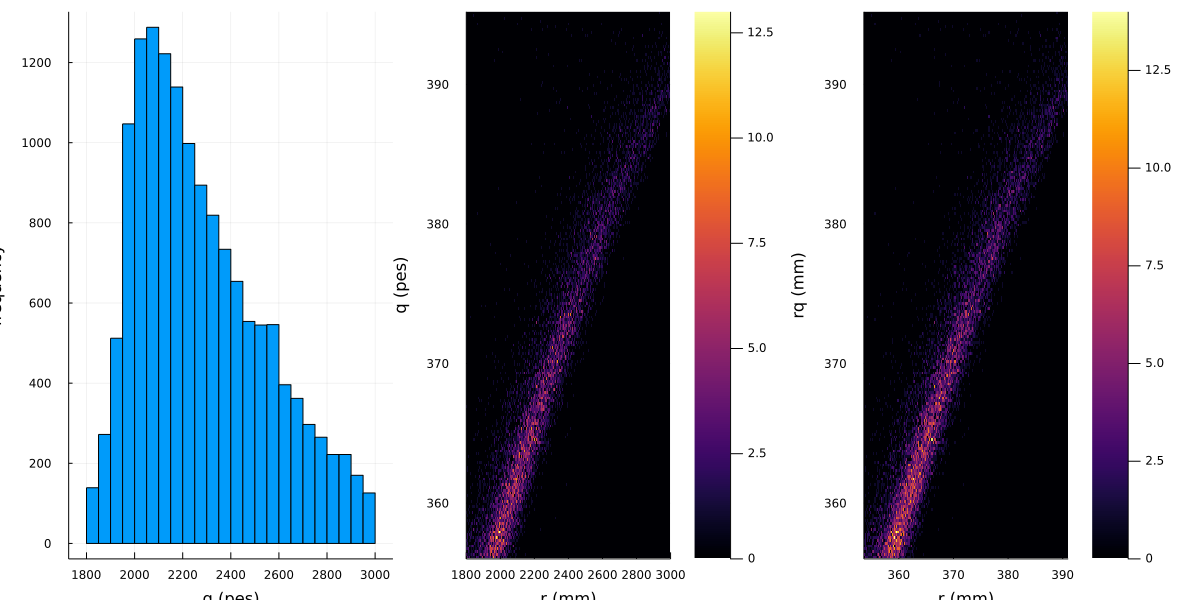

In [551]:
plot(phq, phqr, phrrq, layout = (1, 3), size = (1200, 600), 
     legend=false, fmt = :png)

In [702]:
pqrdf = JPetalo.p1df(n3df.q1, n3df.r1, 50);
lfqr, pqr, cqr = JPetalo.lfit(pqrdf);
cqr

2-element Vector{Float64}:
 299.4805926867708
   0.030804570696522062

In [703]:
prqdf = JPetalo.p1df(n3df.r1, n3df.q1, 50);
lfrq, prq, crq = JPetalo.lfit(prqdf);
crq

2-element Vector{Float64}:
 -6715.7852963598325
    24.35973955412902

In [704]:
pqr = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pqr = plot!(pqr,pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)");

In [705]:
prq = plot(prqdf.x_mean,prqdf.y_mean, yerror=prqdf.y_std, shape = :circle, color = :black, legend=false)
prq = plot!(prq, prqdf.x_mean,lfrq, lw=3, legend=false)
xlabel!("r (mm)")
ylabel!("q (pes)");

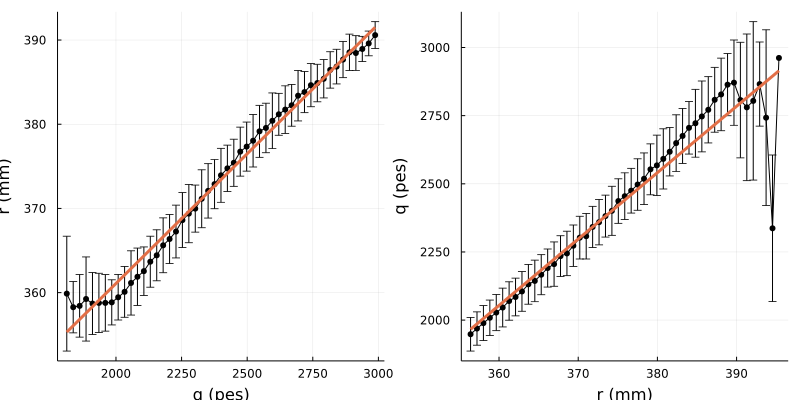

In [706]:
plot(pqr, prq,  layout = (1, 2), size = (800, 400), 
     legend=false, fmt = :png)

### Corrected charge

In [709]:
JPetalo.qcor2!(n3df, x->crq[1] + crq[2] *x, "r1", "q1", "qc1", 2200.0);

In [710]:
x,y,hqcr,phqcr = JPetalo.hist2d(n3df.r1,n3df.qc1, 250, "r (mm)", "q (pes)");

In [711]:
hqc = JPetalo.hist1d(n3df.qc1, 50, 1500., 2500.);
phqc = plot(hqc, xlim=(1500., 3500.), xlabel="q (pes)");

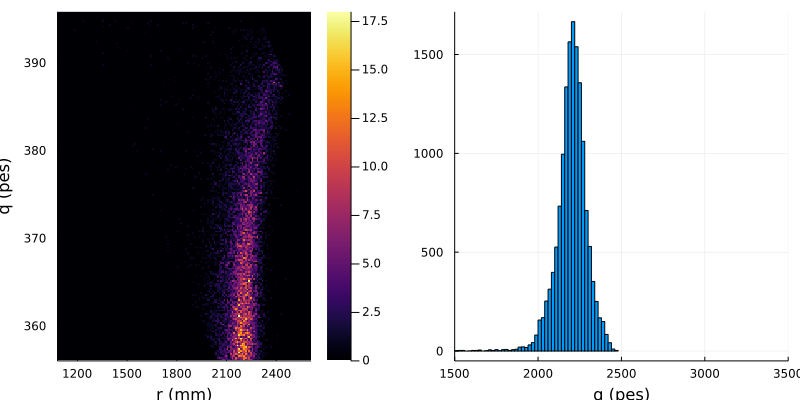

In [712]:
plot(phqcr, phqc, layout = (1, 2), size = (800, 400), 
     legend=false, fmt = :png)

### Number of SiPMs with charge above threshold

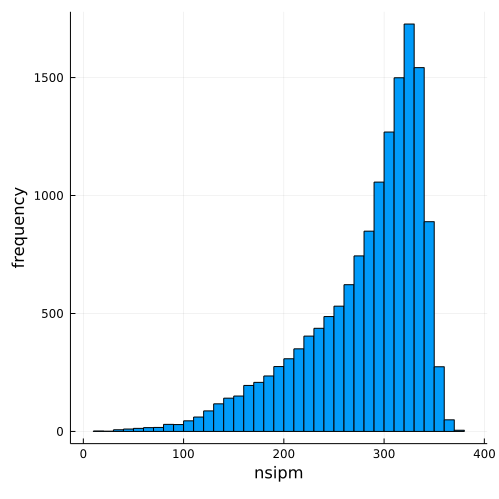

In [622]:
hnsipm, pnsipm = JPetalo.hist1d(n3df.nsipm,  "nsipm", 50);
plot(pnsipm,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)

### std deviation of phi and z (weighted by charge)
- Both are related with radius (not linear relation)
- Fully correlated (at least for phe events)

In [623]:
hphistd, pphistd = JPetalo.hist1d(n3df.phistd, "phistd", 50, 0.0, 0.12);
hzstd, pzstd = JPetalo.hist1d(n3df.zstd, "zstd", 50,  10., 35.);

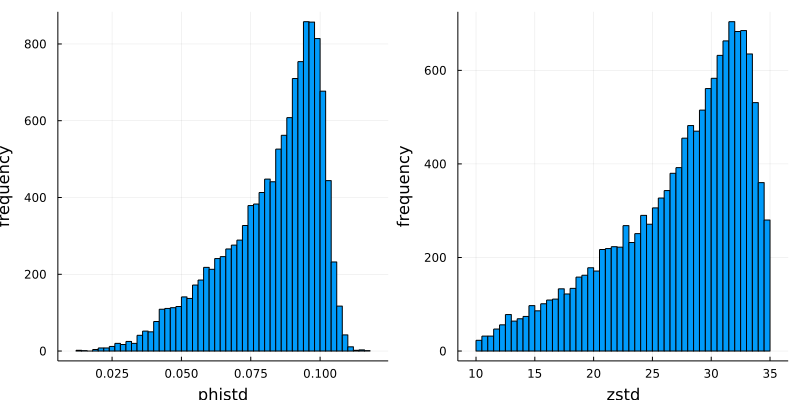

In [624]:
plot(pphistd, pzstd,layout = (1, 2), size = (800, 400), 
     legend=false, fmt = :png)

In [625]:
xe,ye,hrphistd,prphistd = JPetalo.hist2d(n3df.r, n3df.phistd, 250, "phistd", "r (mm)", 360., 390., 0.0,0.12,);

In [626]:
xe,ye,hrzstd,przstd = JPetalo.hist2d(n3df.r, n3df.zstd, 250, "zstd", "r (mm)", 360., 390., 0.0,40.);

In [627]:
xe,ye,hphizstd,pphizstd = JPetalo.hist2d(n3df.phistd, n3df.zstd, 250, "phistd", "zstd", 0.0,0.12, 0.0,40.);

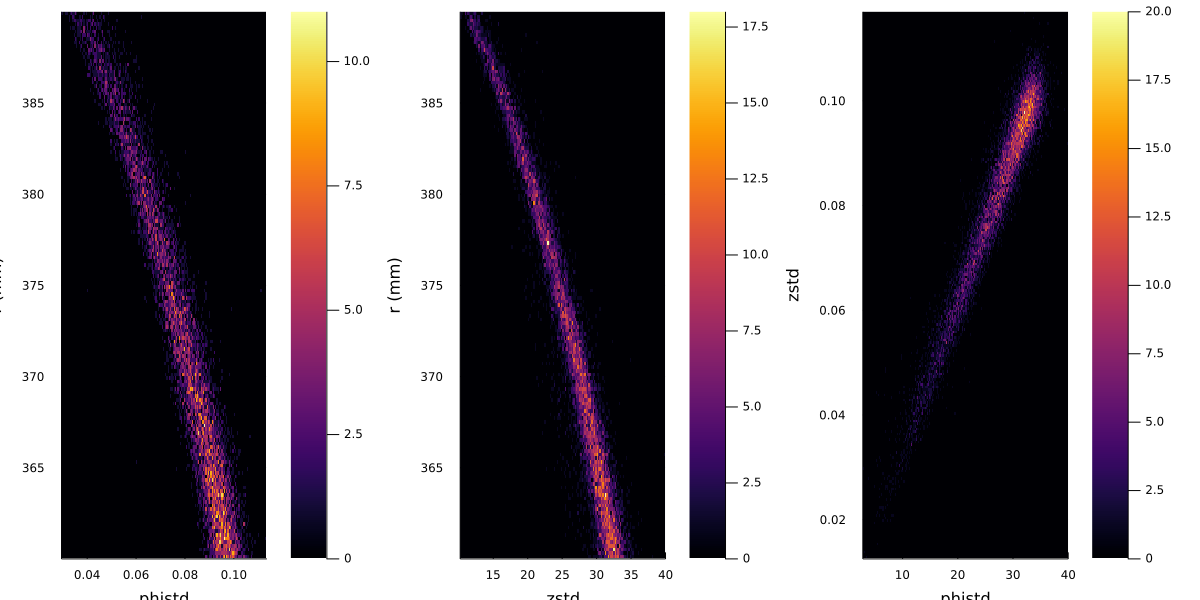

In [628]:
plot(prphistd, przstd, pphizstd, layout = (1, 3), size = (1200, 600), 
     legend=false, fmt = :png)

In [629]:
n3dfr = JPetalo.select_by_column_value_interval(n3df, "r", 350.0, 390.0);

In [630]:
n3dfrz = JPetalo.select_by_column_value_interval(n3dfr, "zstd", 12.0, 35.0);

In [631]:
przdf = JPetalo.p1df(n3dfrz.zstd, n3dfrz.r, 50);

In [632]:
prz = plot(przdf.x_mean,przdf.y_mean, yerror=przdf.y_std, shape = :circle, color = :black, legend=false)
lfrz, prz, crz = JPetalo.lfit(przdf);
crz

2-element Vector{Float64}:
 409.64356041448707
  -1.4779388088677259

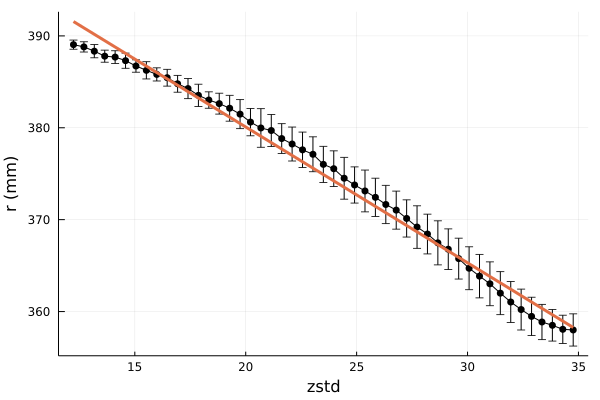

In [633]:
prz = plot(przdf.x_mean,przdf.y_mean, yerror=przdf.y_std, shape = :circle, color = :black, legend=false)
prz = plot!(prz, przdf.x_mean,lfrz, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("zstd")

In [634]:
crz

2-element Vector{Float64}:
 409.64356041448707
  -1.4779388088677259

In [635]:
cqr

2-element Vector{Float64}:
 299.0113400828989
   0.030976491001232075

In [636]:
function rfzstd(z::Float64)
    return crz[1] + crz[2]*z
end

rfzstd (generic function with 2 methods)

In [637]:
function rfq(q::Float64)
    return cqr[1] + cqr[2] * q
end

rfq (generic function with 2 methods)

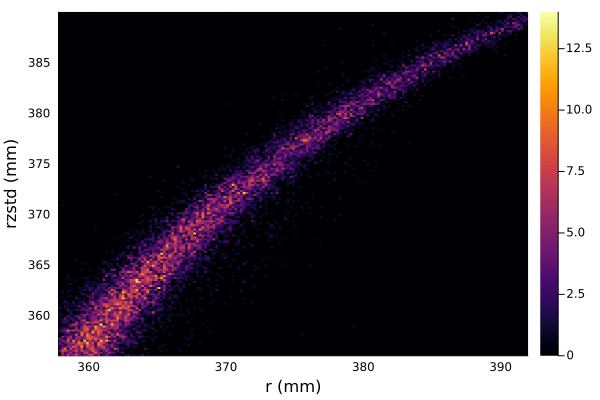

In [638]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3dfrz.r,rfzstd.(n3dfrz.zstd), 250, "r (mm)", "rzstd (mm)");
plot(phqr)

In [579]:
function gfit_gauss(x, xmin, xmax)
    function gausx(x, μ, σ, N)
        return N * exp(-(x - μ)^2/(2*σ^2))
    end
    
    xmu, xstd = JPetalo.mean_std(x, xmin, xmax)
    @debug xmu xstd
    @. gauss1(x, p) = p[1]* exp(-(x - xmu)^2/(2*xstd^2))
    p0 = [1.0]
    
    h = JPetalo.hist1d(n3dfrz.r - rfzstd.(n3dfrz.zstd),  50, -8.0, 8.0)
    edges = collect(h.edges[1])
    w = h.weights
    c =[0.5 *(edges[i] + edges[i+1]) for i in 1:length(edges)-1]
    @debug "histo" edges w c 
    fq = curve_fit(gauss1, c, w, p0)    
    N =coef(fq)[1][1]
    @debug "N" N
    return xmu, xstd, c, gausx.(c, (xmu,), (xstd,), (N),)    
end

gfit_gauss (generic function with 1 method)

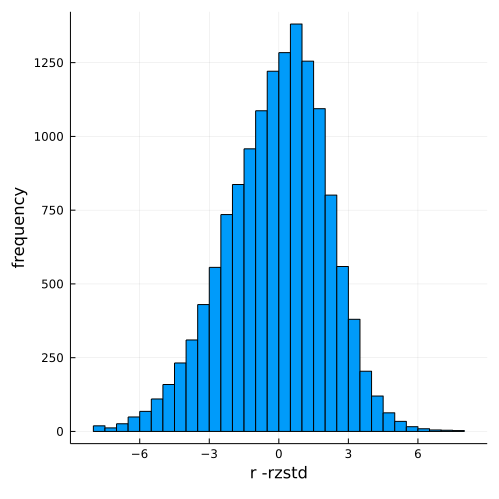

In [639]:
h, p = JPetalo.hist1d(n3dfrz.r - rfzstd.(n3dfrz.zstd),  "r -rzstd", 50, -8.0, 8.0)
plot(p,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)

In [640]:
loglevel("Info")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(42) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

In [641]:
mux, stdx, xg, yg = gfit_gauss(n3dfrz.r - rfzstd.(n3dfrz.zstd), -5.0, 5.0);

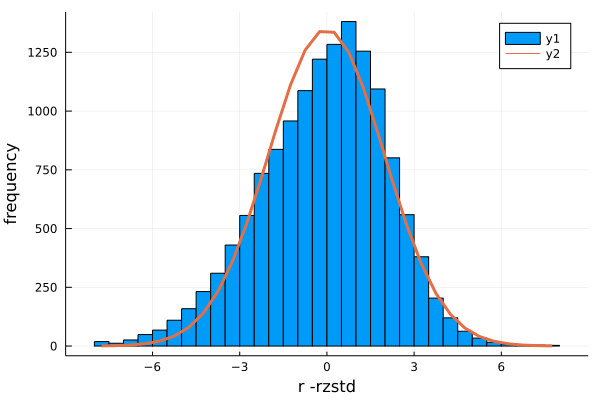

In [642]:
pfit = plot!(p, xg, yg, lw=3)

In [643]:
@info "mean = $mux std =$stdx"

┌ Info: mean = -0.017535823720044655 std =1.989574565456063
└ @ Main In[643]:1


In [644]:
h, p = JPetalo.hist1d(n3dfqr.r - rfq.(n3dfqr.q),  "r -rrq", 50, -10.0, 10.0);

In [645]:
mux, stdx, xg, yg = gfit_gauss(n3dfqr.r - rfq.(n3dfqr.q), -5.0, 5.0);

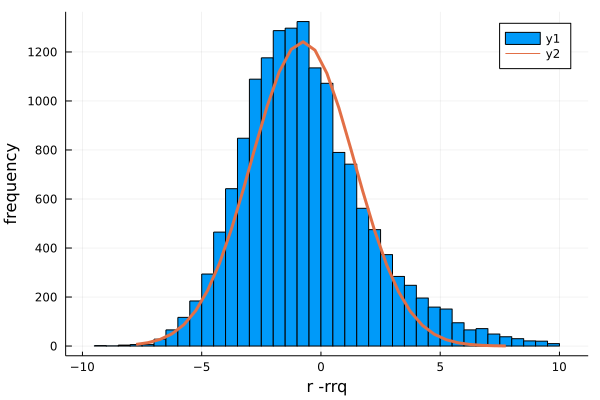

In [646]:
pfit = plot!(p, xg, yg, lw=3)

In [647]:
@info "mean = $mux std =$stdx"

┌ Info: mean = -0.7626392112857455 std =2.1634471708360286
└ @ Main In[647]:1


### Resolution in (x,y,z,r)

In [868]:
hxtxr, pxtxr = JPetalo.hist1d(n3df.xt1 - n3df.xr1, "xt - xr", 50,  -10., 10.);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [869]:
hytyr, pytyr = JPetalo.hist1d(n3df.yt1 - n3df.yr1, "yt - yr", 50,  -10., 10.);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [870]:
hztzr, pztzr = JPetalo.hist1d(n3df.zt1 - n3df.zr1, "zt - zr", 50,  -10., 10.);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [871]:
hrtr, przr = JPetalo.hist1d(n3df.r1 - n3df.rq1, "r - rq", 50,  -10., 10.);
plot(przr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

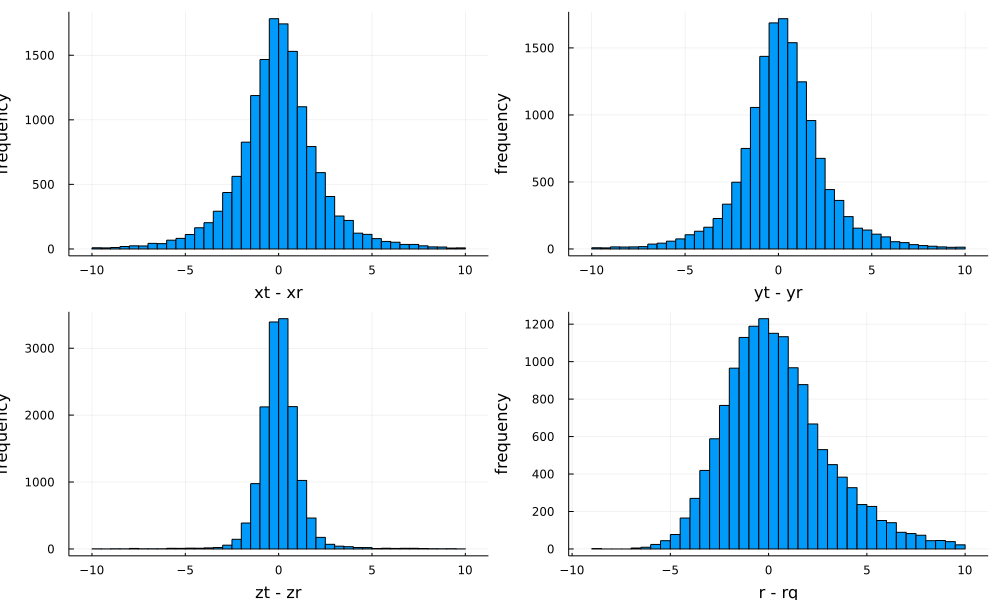

In [872]:
plot(pxtxr, pytyr,pztzr, przr, layout = (2, 2), size = (1000, 600), 
     legend=false, fmt = :png)

In [873]:
xmu, xstd = JPetalo.mean_std(n3df.xt1 - n3df.xr1, -2.5, 2.5)
@printf "Resolution in x (mm) = %5.1f" xstd

Resolution in x (mm) =   1.2

In [874]:
xmu, xstd = JPetalo.mean_std(n3df.yt1 - n3df.yr1, -2.5, 2.5)
@printf "Resolution in y (mm) = %5.1f" xstd

Resolution in y (mm) =   1.2

In [875]:
xmu, xstd = JPetalo.mean_std(n3df.zt1 - n3df.zr1, -2.5, 2.5)
@printf "Resolution in y (mm) = %5.1f" xstd

Resolution in y (mm) =   0.8

In [876]:
xmu, xstd = JPetalo.mean_std(n3df.r1 - n3df.rq1, -5.0, 5.0)
@printf "Resolution in y (mm) = %5.1f" xstd

Resolution in y (mm) =   2.1

In [878]:
@info names(n3df)

┌ Info: ["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "rq1", "rq2", "t1", "t2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]
└ @ Main In[878]:1


In [879]:
n3dfx = JPetalo.select_by_column_value(n3df, "xs", 0.0);

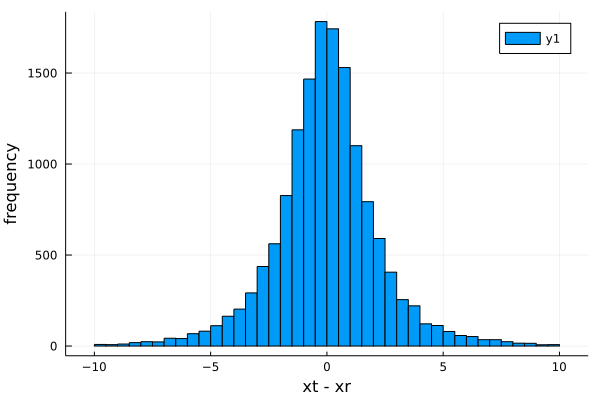

In [880]:
hxtxr, pxtxr = JPetalo.hist1d(n3dfx.xt1 - n3dfx.xr1, "xt - xr", 50,  -10., 10.)
plot(pxtxr)

In [881]:
n3dfxy = JPetalo.select_by_column_value(n3dfx, "ys", 10.0);

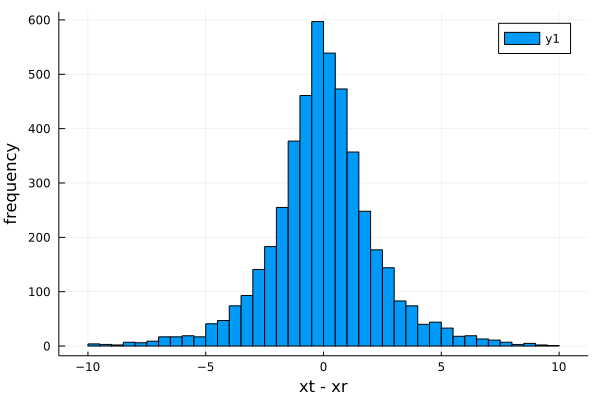

In [882]:
hxtxr, pxtxr = JPetalo.hist1d(n3dfxy.xt1 - n3dfxy.xr1, "xt - xr", 50,  -10., 10.)
plot(pxtxr)

In [883]:
n3dfxyz = JPetalo.select_by_column_value(n3dfxy, "zs", 0.0);

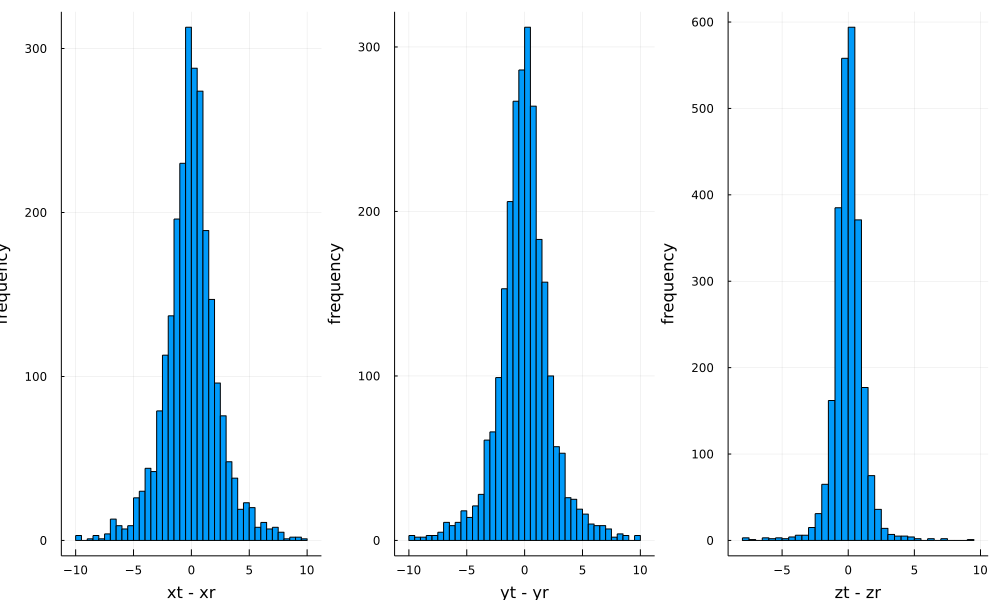

In [884]:
hx, px = JPetalo.hist1d(n3dfxyz.xt1 - n3dfxyz.xr1, "xt - xr", 50,  -10., 10.)
hy, py = JPetalo.hist1d(n3dfxyz.yt1 - n3dfxyz.yr1, "yt - yr", 50,  -10., 10.)
hz, pz = JPetalo.hist1d(n3dfxyz.zt1 - n3dfxyz.zr1, "zt - zr", 50,  -10., 10.)
plot(px, py, pz, layout = (1, 3), size = (1000, 600), legend=false, fmt = :png)

In [885]:
xmu, xstd = JPetalo.mean_std(n3dfxyz.xt1 - n3dfxyz.xr1, -5., 5.)
@printf "Resolution in x (mm) = %5.1f" xstd

Resolution in x (mm) =   1.8

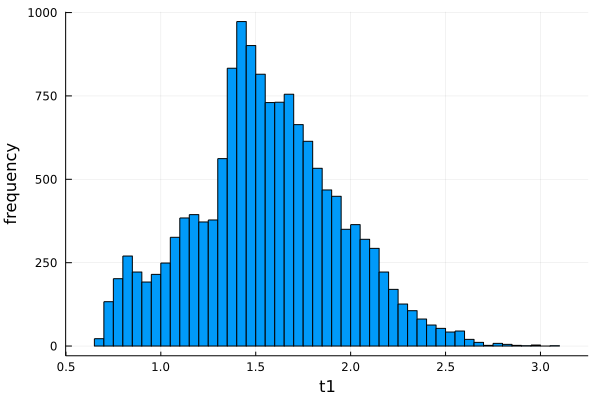

In [886]:
ht1, pt1 = JPetalo.hist1d(n3df.t1, "t1", 50,  -100., 100.)
plot(pt1, legend=false)

In [923]:
function ct12(df; reco=true)
    if reco
        return 1000.0*(df.tr1 - df.tr2)
    else
        return 1000.0 * (df.t1 - df.t2)
    end
end
        


ct12 (generic function with 1 method)

In [908]:
t12 = 1000.0 * (n3dfxyz.t1 - n3dfxyz.t2);

In [914]:
t12 = 1000.0*(n3dfxyz.tr1 - n3dfxyz.tr2);

In [975]:
t12 = ct12(n3dfxyz, reco=true);

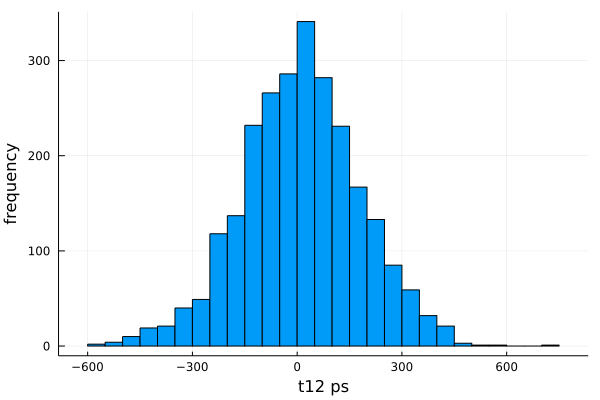

In [976]:
ht1t2, pt1t2 = JPetalo.hist1d(t12, "t12 ps", 50,  -2000., 2000.)
plot(pt1t2, legend=false)

In [977]:
xmu, xstd = JPetalo.mean_std(t12*1000.0, -300.0, 300.0)

(39.999999999965986, 178.54212388119933)

In [917]:
c0 =uconvert(mm/ns, float(SpeedOfLightInVacuum))

299.792458 mm ns⁻¹

In [918]:
cc = convert(Float32, c0/(mm*ns^-1))

299.79245f0

In [955]:
function ctsr(df; reco=true)
    if reco
        tsr1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        
    else
        tsr1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
    end
    return 1000.0*(tsr2 - tsr1)
end

ctsr (generic function with 1 method)

In [978]:
tsr12 = ctsr(n3dfxyz, reco=true);

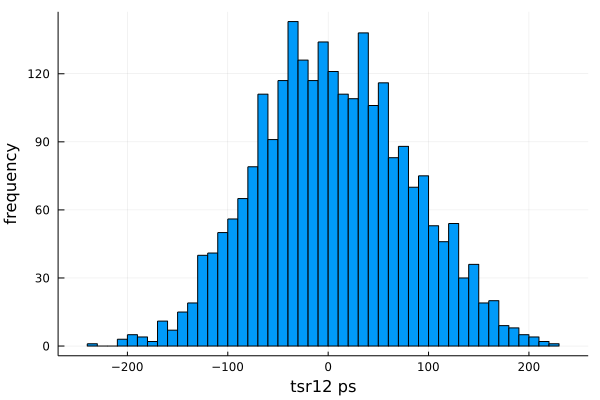

In [979]:
htsr12, psr1t2 = JPetalo.hist1d(tsr12, "tsr12 ps", 50,  -500., 500.)
plot(psr1t2, legend=false) 

In [980]:
xmu, xstd = JPetalo.mean_std(tsr12, -200.0, 200.0)

(5.368266881255396, 73.75147926170891)

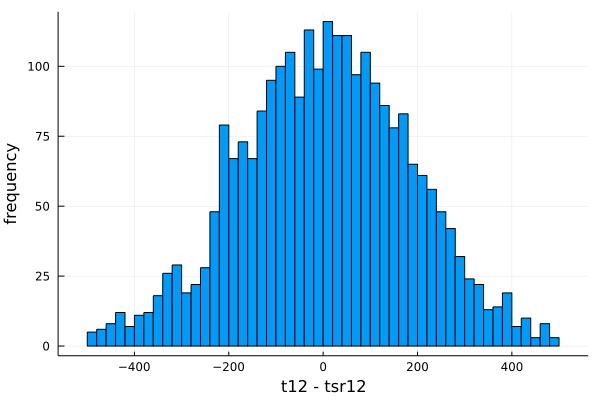

In [981]:
h12, p12 = JPetalo.hist1d(t12-tsr12, "t12 - tsr12", 50,  -500., 500.)
plot!(p12, legend=false) 

In [982]:
xmu, xstd = JPetalo.mean_std(t12-tsr12, -400.0, 400.0)

(6.551269063335126, 166.98125972317314)

In [964]:
function crb(df; reco=true)
    if reco
        trb1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/cc;
        trb2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/cc;
        
    else
        trb1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/cc;
        trb2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/cc;
     end
    return 1000.0*(trb2 - trb1)
end

crb (generic function with 1 method)

In [983]:
trb12 = ctsr(n3dfxyz, reco=true);

In [935]:
trb1 = [JPetalo.dxyz([n3dfxyz.xr1[i], n3dfxyz.yr1[i], n3dfxyz.zr1[i]], [n3dfxyz.xb1[i], n3dfxyz.yb1[i], n3dfxyz.zb1[i]]) for i in 1:nrow(n3dfxyz)]/cc;

In [936]:
trb2 = [JPetalo.dxyz([n3dfxyz.xr2[i], n3dfxyz.yr2[i], n3dfxyz.zr2[i]], [n3dfxyz.xb2[i], n3dfxyz.yb2[i], n3dfxyz.zb2[i]]) for i in 1:nrow(n3dfxyz)]/cc;

In [937]:
trb12 = 1000.0*(trb2 - trb1);

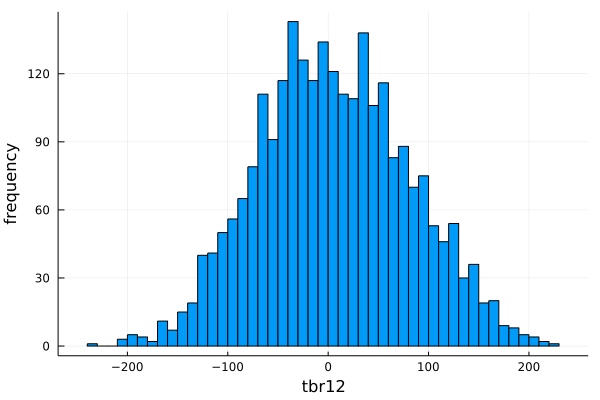

In [984]:
htrb12, ptrb12 = JPetalo.hist1d(trb12, "tbr12", 50,  -500., 500.)
plot(ptrb12, legend=false) 

In [985]:
xmu, xstd = JPetalo.mean_std(trb12, -200.0, 200.0)

(5.368266881255396, 73.75147926170891)

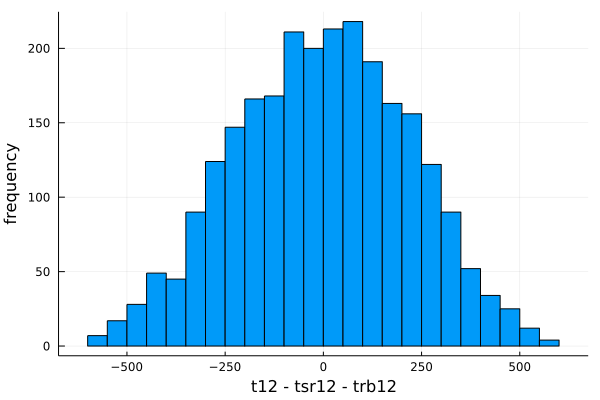

In [989]:
h12, p12 = JPetalo.hist1d(t12-tsr12 - trb12, "t12 - tsr12 - trb12", 50,  -600., 600.)
plot!(p12, legend=false) 

In [990]:
xmu, xstd = JPetalo.mean_std(trb12, -500.0, 500.0)

(5.591267323816779, 74.88261434163077)